# Galaxies vs Quasars with Neural Networks

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard)

In [1]:
import numpy as np
import pandas as pd
import os
import datetime

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve

import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from astroML.utils import completeness_contamination

from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 15

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

In [2]:
data = pd.read_csv('galaxyquasar.csv')
print(data)
data_arr = np.array(data)

u = np.array(data_arr[:,0])
g = np.array(data_arr[:, 1])
r = np.array(data_arr[:, 2])
i = np.array(data_arr[:, 3])
z = np.array(data_arr[:, 4])
c = np.array(data_arr[:, 5]) #array for column class

#(u-g) color
ug = np.array(u-g)
#(g-r) color
gr = np.array(g-r)
#(r-i) color
ri = np.array(r-i)
#(i-z) color
iz = np.array(i-z)

#galaxy = 0, QSO = 1
labels = np.where(c =="QSO", 1, 0)
print(labels)

              u         g         r         i         z   class        z1  \
0      18.97213  18.53676  18.58280  18.34936  18.29215     QSO  0.522819   
1      19.24592  17.47646  16.47817  16.04472  15.68851  GALAXY  0.122846   
2      19.43536  17.70268  16.91565  16.58327  16.39128  GALAXY  0.000000   
3      19.31626  18.18312  17.39591  16.94549  16.65395  GALAXY  0.147435   
4      19.28828  19.11188  18.88937  18.80013  18.49183     QSO  2.011455   
...         ...       ...       ...       ...       ...     ...       ...   
49995  19.37295  18.12382  17.39886  16.98503  16.70585  GALAXY  0.113016   
49996  18.52021  16.88262  16.03280  15.56884  15.22454  GALAXY  0.085063   
49997  18.62718  17.30876  16.87371  16.62399  16.42296  GALAXY  0.054429   
49998  19.55140  18.27711  17.62101  17.21947  17.03347  GALAXY  0.112571   
49999  18.80772  17.75751  17.40500  17.21650  17.12295  GALAXY  0.043652   

           zerr  
0      0.000155  
1      0.000028  
2      0.000000  
3  

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

In [59]:
colors = ['u-g', 'g-r', 'r-i', 'i-z']

#split the dataset
x = np.array([ug, gr, ri, iz]).T

scaler = StandardScaler()
x_scaler = scaler.fit_transform(x)

xtrain, xtest, ytrain, ytest = train_test_split(x_scaler, labels, test_size=0.3, random_state=1)

We plot the distribution of galaxies and QSO vs the differet coloros.

In [61]:
ytrain

array([0, 0, 0, ..., 0, 1, 0])

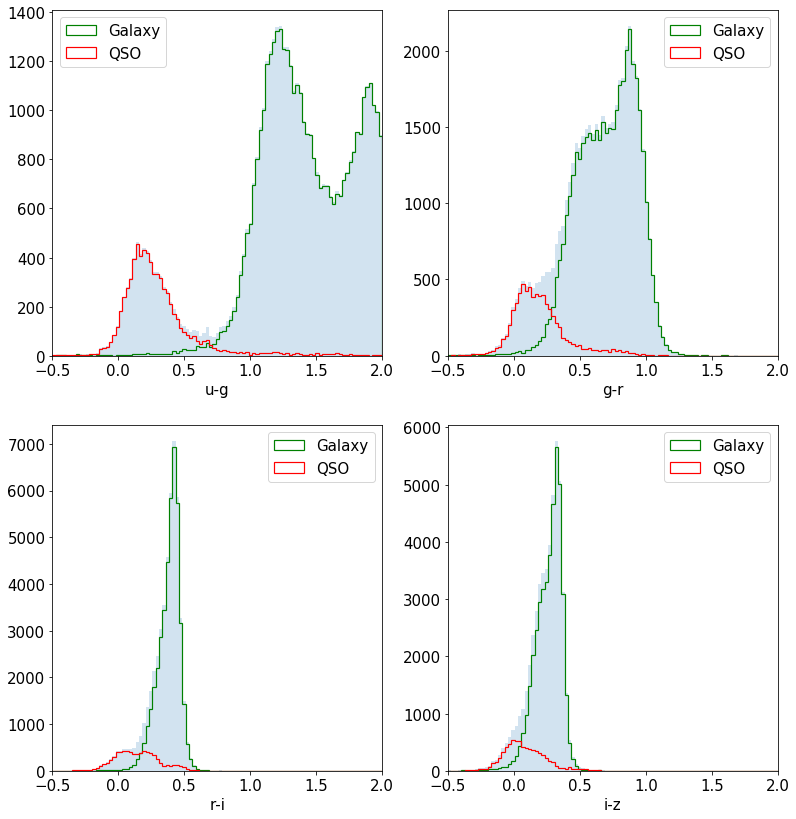

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(13, 14))
axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]
bins = np.linspace(-0.5, 2, 100)

for a, i in zip(axs, range(len(x))):
    a.hist(x[:, i], bins=bins, alpha=0.2)
    a.hist(x[:, i][labels==0], bins=bins, histtype='step', color='green', lw=1.2, label='Galaxy')
    a.hist(x[:, i][labels==1], bins=bins, histtype='step', color='red', lw=1.2, label='QSO')
    
    a.set_xlabel(colors[i])
    a.set_xlim(-0.5, 2)
    a.legend()
plt.show()

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the [multilayer perceptron classifier](sklearn.neural_network.MLPClassifier) implemented in scikit-learn. My solution uses the latter, but this is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

## Train the model with Tensorflow via keras 

In [5]:
def trainnetwork(train_set, test_set, ytrain, ytest, filename):

    if not os.path.isfile(filename):

        train_in  = train_set
        train_out = ytrain
        test_in  = test_set
        test_out = ytest

        # Kernel initializer
        my_init = keras.initializers.glorot_uniform(seed=1)
        # Define neural network architecture
        model = keras.Sequential([
            # Input layer, do not change
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            # Inner layers, can add/change
            keras.layers.Dense(5,  activation='tanh',kernel_initializer=my_init),
            # Output layer, do not change
            keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])

        model.compile(
            # Optimization algorithm, specify learning rate
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            # Loss function for a binary classifier
            loss='binary_crossentropy',
            # Diagnostic quantities
            metrics=['accuracy'])

        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return lr * tf.math.exp(-0.05)

        # Actual Training
        history = model.fit(
            # Training inputs
            train_in,
            # Training outputs
            train_out,
            # Evaluate test set at each epoch
            validation_data=(test_in, test_out),
            # Batch size, default is 32
            # Number of epochs
            epochs=50,
            # Store the model with the best validation accuracy
            callbacks = [
                # Drecrease learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                # Store the model with the best validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                # Save logfiles for tensorboard
                tf.keras.callbacks.TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime
                                               ("%Y%m%d-%H%M%S"), histogram_freq=1)],
            # Shuffle data at each epoch
            shuffle=True)

        # Store the last (not necessarily the best) iteration
        model.save(filename)

    model = loadnetwork(filename)
    return model

In [6]:
def loadnetwork(filename,verbose=False):
    '''
    Load a trained neural network
    '''

    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()

    return model

In [7]:
# Train a neural network
trainnetwork(xtrain, xtest, ytrain, ytest,filename='galvsQSO_trained.h5')

In [8]:
model = loadnetwork('galvsQSO_trained.h5')

In [9]:
test_loss, test_acc = model.evaluate(xtest,  ytest, verbose=2)

print('\nTest accuracy:', test_acc)

469/469 - 3s - loss: 0.0473 - accuracy: 0.9865 - 3s/epoch - 7ms/step

Test accuracy: 0.9865333437919617


In [55]:
train_pred = np.squeeze((model.predict(xtrain) > 0.5).astype("int32"))
test_pred = np.squeeze((model.predict(xtest) > 0.5).astype("int32"))

1094/1094 [==============================] - 4s 3ms/step
[0 0 0 ... 0 1 0]
469/469 [==============================] - 2s 3ms/step


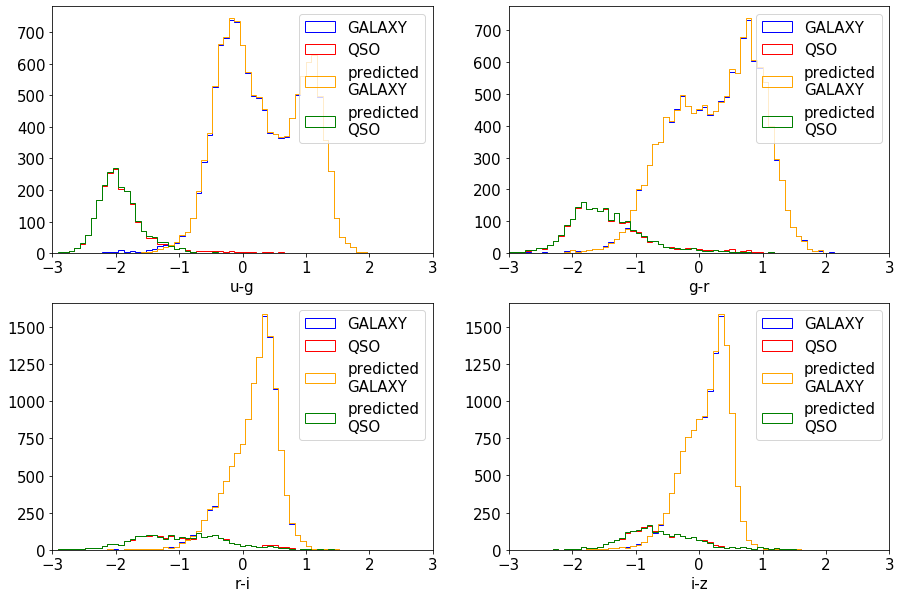

In [11]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]
bins=np.linspace(-3, 3, 70)

for a,i in zip(axs, range(len(x_scaler))):
    a.hist(xtest[:,i][ytest==0], bins=bins, histtype='step', lw=1, label='GALAXY', color='b')
    a.hist(xtest[:,i][ytest==1], bins=bins, histtype='step', lw=1, label='QSO', color='red')
    a.hist(xtest[:,i][test_pred==0], bins=bins, histtype='step', lw=1, label='predicted\nGALAXY', color='orange')
    a.hist(xtest[:,i][test_pred==1], bins=bins, histtype='step', lw=1, label='predicted\nQSO', color='green')
    
    a.set_xlabel(colors[i])
    a.set_xlim(-3,3)
    a.legend()

plt.show()

By observing the plot seem that the neural network classified quite well the distributions. To quantify the goodness we compute the accuracy, confusion matrix, completeness and contamination.

In [12]:
accuracy_train = accuracy_score(ytrain, train_pred)
accuracy_test = accuracy_score(ytest, test_pred)

print('The accuracy of the training set is:', round(accuracy_train,3))
print('The accuracy of the test set is:', round(accuracy_test,3))

confusion_train = confusion_matrix(ytrain, train_pred)
confusion_test = confusion_matrix(ytest, test_pred)

print('\n The confusion matrix of the training set is: \n',  confusion_train)
print('\n The confusion matrix of the test set is: \n',  confusion_test)

completeness, contamination = completeness_contamination(test_pred, ytest)

print("\nThe completeness is:", round(float(completeness),3))
print("The contamination is:", round(float(contamination),3))

The accuracy of the training set is: 0.987
The accuracy of the test set is: 0.987

 The confusion matrix of the training set is: 
 [[29852   178]
 [  289  4681]]

 The confusion matrix of the test set is: 
 [[12737    99]
 [  103  2061]]

The completeness is: 0.952
The contamination is: 0.046


We are happy with the results. Now we plot the ROC curve.

469/469 [==============================] - 2s 4ms/step


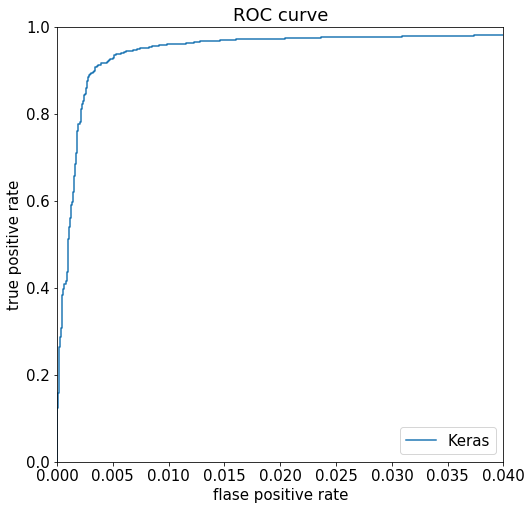

In [13]:
prob = model.predict(xtest)

#for Keras
fpr, tpr, threshold = roc_curve(ytest, prob)

plt.plot(fpr, tpr, label='Keras')
plt.title('ROC curve')
plt.xlabel('flase positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,0.04)
plt.ylim(0.,1)
plt.legend(loc='lower right')
plt.show()

## Train the model with Multilayer Preceptor Classifier

Now we train our model with another classifier such as: Multilayer Preceptron Classifier. Reminder:
3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

In [14]:
classif = MLPClassifier(hidden_layer_sizes=5, activation='relu', 
                        solver='adam', alpha=0, learning_rate_init=0.001,
                       max_iter=200)

In [15]:
classif.fit(xtrain, ytrain)

MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=5, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

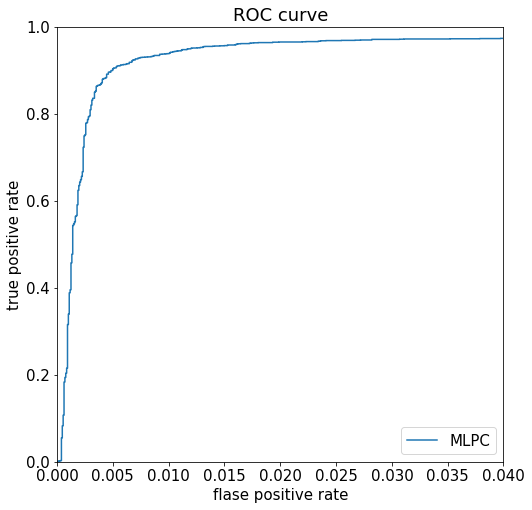

In [16]:
y_prob = classif.predict_proba(xtest)[:,1]

fpr, tpr, threshold = roc_curve(ytest, y_prob)

plt.plot(fpr, tpr, label='MLPC')
plt.title('ROC curve')
plt.xlabel('flase positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,0.04)
plt.ylim(0.,1)
plt.legend(loc='lower right')
plt.show()

Now we plot the ROC curve of Keras vs Multilayer Preceptor Classifier.

469/469 [==============================] - 2s 4ms/step


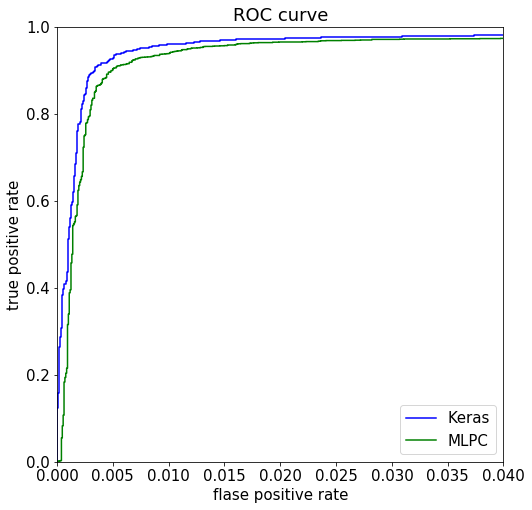

In [17]:
#Multilayer Classifier
y_prob = classif.predict_proba(xtest)[:,1]
fpr_MLPC, tpr_MLPC, threshold_MLPC = roc_curve(ytest, y_prob)

#for Keras
prob = model.predict(xtest)
fpr_k, tpr_k, threshold_k = roc_curve(ytest, prob)

plt.plot(fpr_k, tpr_k, label='Keras', color='b')
plt.plot(fpr_MLPC, tpr_MLPC, label='MLPC', color='green')
plt.title('ROC curve')
plt.xlabel('flase positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,0.04)
plt.ylim(0.,1)
plt.legend(loc='lower right')
plt.show()

We observe from the plot that the best classifier is Keras. 

## Optimization of the hyperparameters

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?

We optimize the hyperparameters of our network with Keras Tuner.

In [42]:
pip install keras-tuner --upgrade

Keyring is skipped due to an exception: 'keyring.backends'
Requirement already up-to-date: keras-tuner in /home/federica/anaconda/lib/python3.7/site-packages (1.4.6)
Note: you may need to restart the kernel to use updated packages.


We write a function that creates and returns a Keras model.

In [107]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(4,)))

    #hp argument used to define the hyperparameters
    hp_units = hp.Int('units', min_value=5, max_value=50, step=2)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    #tune the learnig rate, by choosing the optimal value from 0.01, 0.001 and 0.001
    hp_lr = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_lr),
                loss='binary_crossentropy',
                metrics=['accuracy'])

    return model



In [108]:
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [109]:
tuner.search(xtrain, ytrain, epochs=50, validation_split=0.2)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""The optimal numebr of units for the layer is {best_hps.get('units')}, 
      and the optimal learning rate for the optimizer is {best_hps.get('learning rate')}""")

The optimal numebr of units for the layer is 36, 
      and the optimal learning rate for the optimizer is 0.01


Now we want to find the optimal number of epochs to train the model with the hyperparimeters obtained.

In [110]:
model = tuner.hypermodel.build(best_hps)
hist = model.fit(xtrain, ytrain, epochs=50, validation_split=0.2)

val_accepted_epoch = hist.history['val_accuracy']

Epoch 1/50
875/875 [==============================] - 7s 7ms/step - loss: 0.0938 - accuracy: 0.9807 - val_loss: 0.1302 - val_accuracy: 0.9813
Epoch 2/50
875/875 [==============================] - 5s 5ms/step - loss: 0.0793 - accuracy: 0.9827 - val_loss: 0.0789 - val_accuracy: 0.9821
Epoch 3/50
875/875 [==============================] - 5s 5ms/step - loss: 0.0749 - accuracy: 0.9824 - val_loss: 0.1349 - val_accuracy: 0.9833
Epoch 4/50
875/875 [==============================] - 5s 5ms/step - loss: 0.0723 - accuracy: 0.9832 - val_loss: 0.0868 - val_accuracy: 0.9840
Epoch 5/50
875/875 [==============================] - 5s 5ms/step - loss: 0.0695 - accuracy: 0.9830 - val_loss: 0.0797 - val_accuracy: 0.9830
Epoch 6/50
875/875 [==============================] - 5s 5ms/step - loss: 0.0742 - accuracy: 0.9836 - val_loss: 0.0770 - val_accuracy: 0.9834
Epoch 7/50
875/875 [==============================] - 5s 5ms/step - loss: 0.0701 - accuracy: 0.9836 - val_loss: 0.0782 - val_accuracy: 0.9831
Epoch 

In [111]:
best_epoch = val_accepted_epoch.index(max(val_accepted_epoch))+1
print('The best epoch is:', best_epoch)

The best epoch is: 32


Now we want to retrain our model.

In [112]:
hypermodel = tuner.hypermodel.build(best_hps)

#Re-train the model
hypermodel.fit(xtrain, ytrain, epochs=best_epoch, validation_split=0.2)

Epoch 1/32
875/875 [==============================] - 7s 6ms/step - loss: 0.0987 - accuracy: 0.9773 - val_loss: 0.0808 - val_accuracy: 0.9821
Epoch 2/32
875/875 [==============================] - 5s 6ms/step - loss: 0.0767 - accuracy: 0.9826 - val_loss: 0.1150 - val_accuracy: 0.9823
Epoch 3/32
875/875 [==============================] - 5s 6ms/step - loss: 0.0766 - accuracy: 0.9824 - val_loss: 0.0815 - val_accuracy: 0.9833
Epoch 4/32
875/875 [==============================] - 4s 5ms/step - loss: 0.0742 - accuracy: 0.9829 - val_loss: 0.0788 - val_accuracy: 0.9827
Epoch 5/32
875/875 [==============================] - 4s 5ms/step - loss: 0.0752 - accuracy: 0.9833 - val_loss: 0.0833 - val_accuracy: 0.9830
Epoch 6/32
875/875 [==============================] - 4s 5ms/step - loss: 0.0735 - accuracy: 0.9833 - val_loss: 0.0708 - val_accuracy: 0.9840
Epoch 7/32
875/875 [==============================] - 4s 5ms/step - loss: 0.0684 - accuracy: 0.9835 - val_loss: 0.0945 - val_accuracy: 0.9839
Epoch 

In [113]:
train_pred_hp = np.squeeze(hypermodel.predict(xtrain) > 0.5).astype("int32")
print(train_pred_hp)
test_pred_hp = np.squeeze((hypermodel.predict(xtest) > 0.5).astype("int32"))
print(test_pred_hp)

1094/1094 [==============================] - 4s 4ms/step
[0 0 0 ... 0 1 0]
469/469 [==============================] - 2s 4ms/step
[0 0 0 ... 0 0 0]


In [114]:
accuracy_train_hp = accuracy_score(ytrain, train_pred_hp)
accuracy_test_hp = accuracy_score(ytest, test_pred_hp)

print('The accuracy of the training set is:', round(accuracy_train_hp,3))
print('The accuracy of the test set is:', round(accuracy_test_hp,3))

confusion_train_hp = confusion_matrix(ytrain, train_pred_hp)
confusion_test_hp = confusion_matrix(ytest, test_pred_hp)

print('\n The confusion matrix of the training set is: \n',  confusion_train_hp)
print('\n The confusion matrix of the test set is: \n',  confusion_test_hp)

completeness_hp, contamination_hp = completeness_contamination(test_pred_hp, ytest)

print("\nThe completeness is:", round(float(completeness_hp),3))
print("The contamination is:", round(float(contamination_hp),3))

The accuracy of the training set is: 0.985
The accuracy of the test set is: 0.986

 The confusion matrix of the training set is: 
 [[29877   153]
 [  376  4594]]

 The confusion matrix of the test set is: 
 [[12758    78]
 [  127  2037]]

The completeness is: 0.941
The contamination is: 0.037


We are happy with the results we obtained. Now we plot the ROC curve against Keras and MLP Classifier, to see which is the best classifier.

469/469 [==============================] - 2s 4ms/step


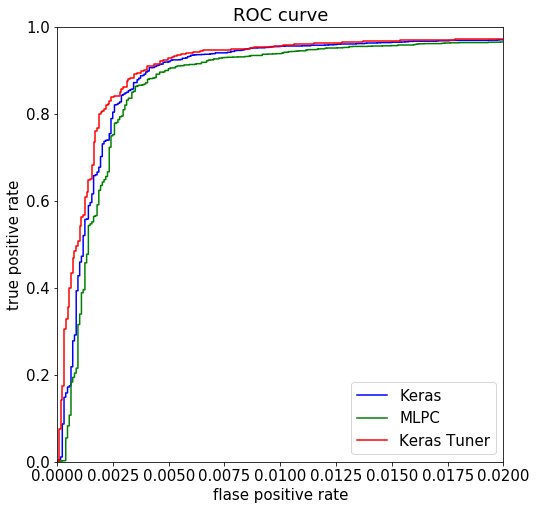

In [115]:
#Multilayer Classifier
prob_MLPC = classif.predict_proba(xtest)[:,1]
fpr_MLPC, tpr_MLPC, threshold_MLPC = roc_curve(ytest, prob_MLPC)

#for Keras
prob_k = model.predict(xtest)
fpr_k, tpr_k, threshold_k = roc_curve(ytest, prob_k)

#for Keras Tuner
prob_tune = hypermodel.predict(xtest)
fpr_hp, tpr_hp, threshold_hp = roc_curve(ytest, prob_tune)

plt.plot(fpr_k, tpr_k, label='Keras', color='b')
plt.plot(fpr_MLPC, tpr_MLPC, label='MLPC', color='green')
plt.plot(fpr_hp, tpr_hp, label='Keras Tuner', color='red')
plt.title('ROC curve')
plt.xlabel('flase positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,0.02)
plt.ylim(0.,1)
plt.legend(loc='lower right')
plt.show()

As we expected Keras Tuner is the best classifier.

## New model to train 

Now we create a model with 36 neurons and a learning rate equal to 0.01.

In [116]:
def trainnetwork(train_set, test_set, ytrain, ytest, filename):

    if not os.path.isfile(filename):

        train_in  = train_set
        train_out = ytrain
        test_in  = test_set
        test_out = ytest

        # Kernel initializer
        my_init = keras.initializers.glorot_uniform(seed=1)
        # Define neural network architecture
        model = keras.Sequential([
            # Input layer, do not change
            tf.keras.layers.InputLayer(input_shape=np.shape(train_in[0])),
            # Inner layers, can add/change
            keras.layers.Dense(36,  activation='tanh',kernel_initializer=my_init),
            # Output layer, do not change
            keras.layers.Dense(1, activation='sigmoid',kernel_initializer=my_init)])

        model.compile(
            # Optimization algorithm, specify learning rate
            optimizer=keras.optimizers.Adam(learning_rate=0.01),
            # Loss function for a binary classifier
            loss='binary_crossentropy',
            # Diagnostic quantities
            metrics=['accuracy'])

        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return lr
            else:
                return lr * tf.math.exp(-0.05)

        # Actual Training
        history = model.fit(
            # Training inputs
            train_in,
            # Training outputs
            train_out,
            # Evaluate test set at each epoch
            validation_data=(test_in, test_out),
            # Batch size, default is 32
            # Number of epochs
            epochs=50,
            # Store the model with the best validation accuracy
            callbacks = [
                # Drecrease learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                # Store the model with the best validation accuracy
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True),
                # Save logfiles for tensorboard
                tf.keras.callbacks.TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime
                                               ("%Y%m%d-%H%M%S"), histogram_freq=1)],
            # Shuffle data at each epoch
            shuffle=True)

        # Store the last (not necessarily the best) iteration
        model.save(filename)

    model = loadnetwork(filename)
    return model

In [117]:
def loadnetwork(filename,verbose=False):
    '''
    Load a trained neural network
    '''

    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()

    return model

In [118]:
# Train a neural network
trainnetwork(xtrain, xtest, ytrain, ytest,filename='galvsQSO_better_trained.h5')

Epoch 1/50
1094/1094 [==============================] - 8s 6ms/step - loss: 0.0858 - accuracy: 0.9754 - val_loss: 0.0642 - val_accuracy: 0.9833 - lr: 0.0100
Epoch 2/50
1094/1094 [==============================] - 6s 6ms/step - loss: 0.0604 - accuracy: 0.9839 - val_loss: 0.0618 - val_accuracy: 0.9831 - lr: 0.0100
Epoch 3/50
1094/1094 [==============================] - 7s 6ms/step - loss: 0.0569 - accuracy: 0.9842 - val_loss: 0.0541 - val_accuracy: 0.9849 - lr: 0.0100
Epoch 4/50
1094/1094 [==============================] - 8s 7ms/step - loss: 0.0550 - accuracy: 0.9844 - val_loss: 0.0523 - val_accuracy: 0.9849 - lr: 0.0100
Epoch 5/50
1094/1094 [==============================] - 9s 8ms/step - loss: 0.0544 - accuracy: 0.9845 - val_loss: 0.0537 - val_accuracy: 0.9840 - lr: 0.0100
Epoch 6/50
1094/1094 [==============================] - 7s 7ms/step - loss: 0.0531 - accuracy: 0.9849 - val_loss: 0.0496 - val_accuracy: 0.9854 - lr: 0.0100
Epoch 7/50
1094/1094 [==============================] - 7s

In [120]:
model_1 = loadnetwork('galvsQSO_better_trained.h5')

In [121]:
test_loss_1, test_acc_1 = model_1.evaluate(xtest,  ytest, verbose=2)

print('\nTest accuracy:', test_acc_1)

469/469 - 2s - loss: 0.0478 - accuracy: 0.9863 - 2s/epoch - 3ms/step

Test accuracy: 0.9863333106040955


In [122]:
train_pred_1 = np.squeeze((model.predict(xtrain) > 0.5).astype("int32"))
test_pred_1 = np.squeeze((model.predict(xtest) > 0.5).astype("int32"))

469/469 [==============================] - 2s 3ms/step


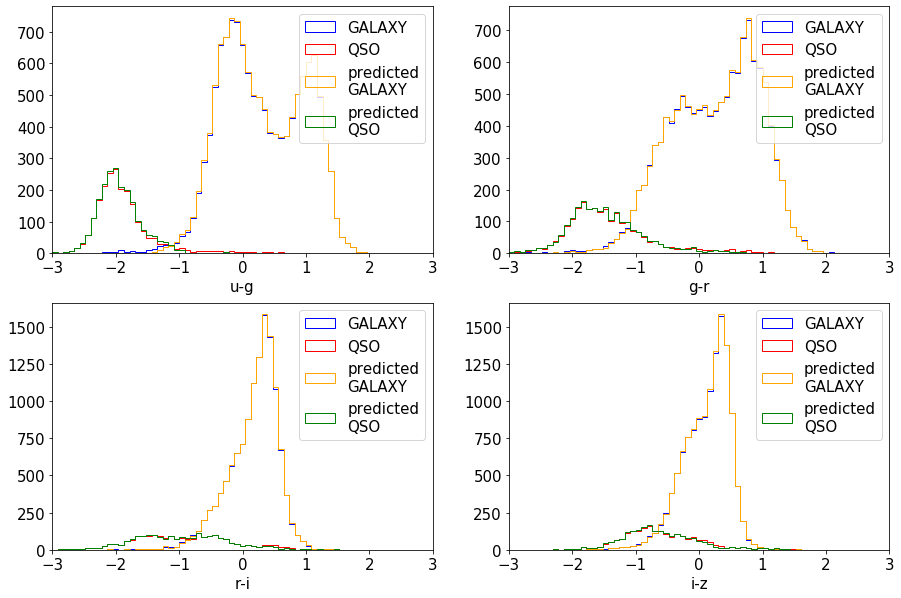

In [123]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]
bins=np.linspace(-3, 3, 70)

for a,i in zip(axs, range(len(x_scaler))):
    a.hist(xtest[:,i][ytest==0], bins=bins, histtype='step', lw=1, label='GALAXY', color='b')
    a.hist(xtest[:,i][ytest==1], bins=bins, histtype='step', lw=1, label='QSO', color='red')
    a.hist(xtest[:,i][test_pred==0], bins=bins, histtype='step', lw=1, label='predicted\nGALAXY', color='orange')
    a.hist(xtest[:,i][test_pred==1], bins=bins, histtype='step', lw=1, label='predicted\nQSO', color='green')
    
    a.set_xlabel(colors[i])
    a.set_xlim(-3,3)
    a.legend()

plt.show()